# k-Nearest Neighbors - Visualizations
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from scipy.interpolate import griddata
import numpy as np
import imageio as iio

from kNN__utils import *

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)

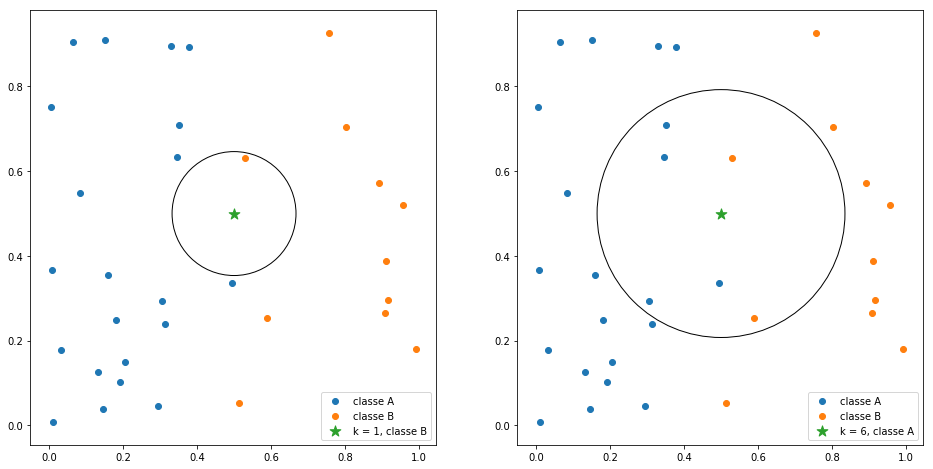

In [3]:
N = 32
np.random.seed(sum([ord(c) for c in 'k-nearest neighbors']))
q1 = np.random.uniform(0, 1, N)
q2 = np.random.uniform(0, 1, N)
cl = q1 >= 0.5

fig, axs = plt.subplots(1, 2)

r = [1024*15, 1024*60]
l = ['k = 1, classe B', 'k = 6, classe A']
for i, ax in enumerate(axs):
    ax.scatter(q1[~cl], q2[~cl], label='classe A')
    ax.scatter(q1[cl], q2[cl], label='classe B')
    ax.scatter(0.5, 0.5, marker='*',
               s=128, label=l[i])
    sc = ax.scatter(0.5, 0.5, s=r[i],
                    edgecolors='black',
                    facecolor='none')
    ax.legend()
fig.savefig('output/kNN_introduction.png', bbox_inches='tight')
plt.show()

## 2. Classification
---

In [4]:
class kNNClass(Distance):
    def __init__(self, k=1):
        super(kNNClass, self).__init__()
        self._k = k
        self._q = None
        self._class = None
    
    def fit(self, X, y):
        self._q = X
        self._class = y
    
    def pred(self, P):
        y, NNs = [], []
        for i, p in enumerate(P):
            dist = self.distance(p, self._q)
            odist = np.argsort(dist)[:self._k]
            fdist = np.ravel(self._class[odist])
            hist = np.bincount(fdist)
            index = np.argmax(hist)
            y += [index]
            NNs += [odist]
        return np.array(y), np.array(NNs)

In [5]:
# Synthetic data 1
q1, q2, CL = synthData1()
Q = np.array([q1, q2]).T

P = [[0.5, 0.5]]
colors = ['#FF00AA', '#AAFF00', '#00AAFF']

In [6]:
%%time
fig, [axA, axB] = plt.subplots(1, 2)

K = 20

def animation(frame):
    axA.cla()
    knnc = kNNClass(frame + 1)
    knnc.fit(Q, y=CL)
    y_, NNs = knnc.pred(P)

    axA.scatter(*Q[CL == 0].T, c=colors[0], label='class 0')
    axA.scatter(*Q[CL == 1].T, c=colors[1], label='class 1')
    axA.scatter(*Q[CL == 2].T, c=colors[2], label='class 2')
    
    hist = np.bincount(CL[NNs[0]], minlength=3)
    axB.bar(0, hist[0] + 0.1, color=colors[0])
    axB.bar(1, hist[1] + 0.1, color=colors[1])
    axB.bar(2, hist[2] + 0.1, color=colors[2])
    axB.set_ylim([0, K])

    for i, c in enumerate(y_):
        axA.scatter(0.5, 0.5, marker='*', s=256, c=colors[c], label='class %s' % c)
        for index in NNs[i]:
            p1 = [P[i][0], Q[index][0]]
            p2 = [P[i][1], Q[index][1]]
            axA.plot(p1, p2, ':', alpha=0.25, c='black', zorder=0)
    axA.legend()
    axA.text(1, 0, 'k = {0:02d}'.format(frame + 1), fontsize =32, ha='right')
    
    plt.axis('off')
    
    return fig.canvas.draw()

anim = manim.FuncAnimation(fig, animation, frames=K, interval=500)
    
anim.save('output/kNN_classificationA.gif', writer="imagemagick", extra_args="convert")
plt.close()

# Solve repetition problem
! magick convert output/kNN_classificationA.gif -loop 0 output/kNN_classificationA.gif
! echo GIF exported and reconverted. Disregard the any message above.

GIF exported and reconverted. Disregard the any message above.
Wall time: 11.9 s


In [7]:
# Synthetic data 2
p1, p2 = synthData2()
P = np.array([p1, p2]).T

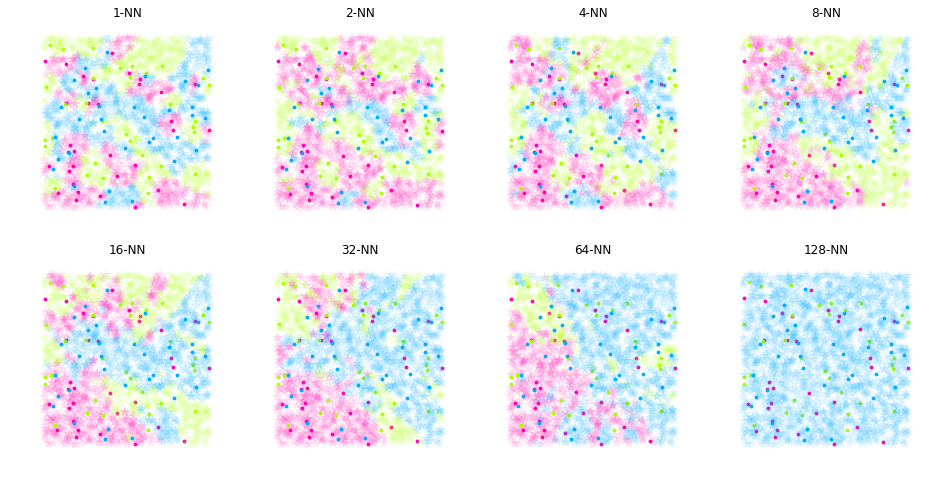

Wall time: 2.48 s


In [8]:
%%time
fig, axs = plt.subplots(2, 4)

for i, ax in np.ndenumerate(axs):
    t, s = i
    k = 2**(4*t + s)
    knnc = kNNClass(k)
    knnc.fit(Q, y=CL)

    y_, _ = knnc.pred(P)
    y_ = np.asarray(y_)
    for j in range(3):
        ax.scatter(*Q[CL == j].T,
                   c=colors[j], s=8)
        ax.scatter(*P[y_ == j].T,
                   marker='*',
                   alpha=0.1,
                   c=colors[j],
                   s=128,
                   edgecolors='none')

    ax.set_title('%s-NN' % k)
    ax.axis('off')

fig.savefig('output/kNN_classificationB.png', bbox_inches='tight')
plt.show()

## 3. Regression
---

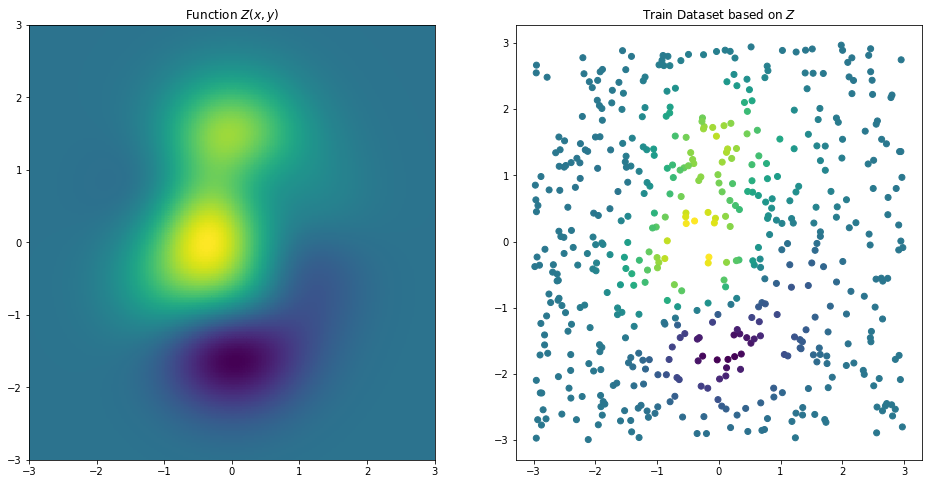

In [9]:
fig, (axA, axB) = plt.subplots(1, 2)

# Synthetic data 3 and 4
X, Y, Z = synthData3()
Q1, Q2, VL = synthData4()
Q = np.array([Q1, Q2]).T

axA.pcolormesh(X, Y, Z); axA.set_title(r'Function $Z(x, y)$')
axB.scatter(*Q.T, c=VL); axB.set_title(r'Train Dataset based on $Z$')
fig.savefig('output/kNN_regressionA.png', bbox_inches='tight')
plt.show()

In [10]:
class kNNRegr(Distance):
    def __init__(self, k=1):
        super(kNNRegr, self).__init__()
        self._k = k
        self._q = None
        self._v = None
    
    def fit(self, X, y):
        self._q = X
        self._v = y
        
    def pred(self, P):
        y, NNs = [], []
        for i, p in enumerate(P):
            dist = self.distance(p, self._q)
            odist = np.argsort(dist)[:self._k]
            fdist = np.ravel(self._v[odist])
            ndist = dist[odist]
            ndist /= np.sum(ndist)
            y += [np.sum(fdist*np.flipud(ndist))]
            NNs += [odist]
        return np.array(y), np.array(NNs)

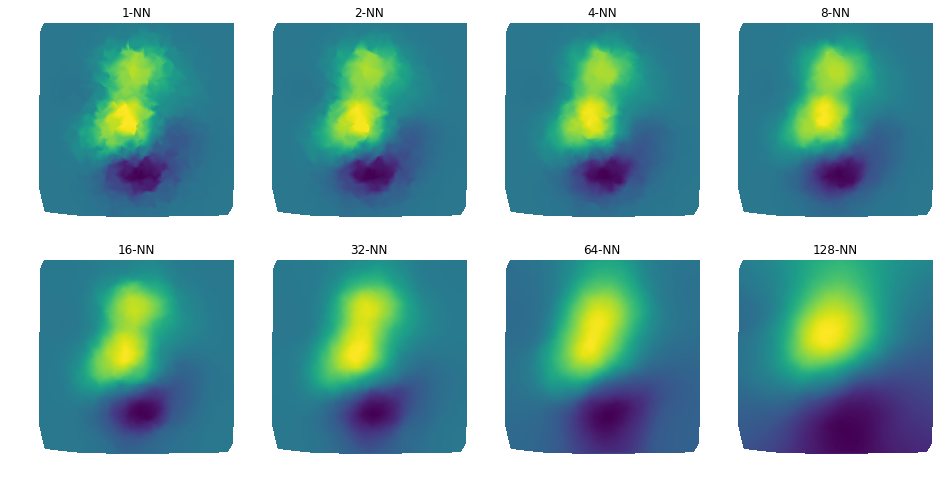

Wall time: 5.56 s


In [11]:
%%time
fig, axs = plt.subplots(2, 4)

# Synthetic data 5
P, xi, yi = synthData5()

for i, ax in np.ndenumerate(axs):
    t, s = i
    k = 2**(4*t + s)
    knnr = kNNRegr(k)
    knnr.fit(Q, y=VL)
    
    y_, NNs = knnr.pred(P)
    y_ = np.asarray(y_)

    zi = griddata(P, y_, (yi, -xi), method='linear')
    ax.imshow(zi)
    ax.set_title('%s-NN' % k)
    ax.axis('off')

fig.savefig('output/kNN_regressionB.png', bbox_inches='tight')
plt.show()